In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from category_encoders import *
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# conda install -c anaconda seaborn

Запись из CSV-файла в объект DataFrame и его представление

In [2]:
df = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';', decimal = ",")
print(df.shape)
df.head()

(170746, 15)


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [3]:
# удаение солбца client_id, cоздание рабочей копии: credit_df
credit_df = df.drop(df.columns[0], axis='columns').copy()

In [4]:
# cписок столбцов
credit_df.columns.tolist()

['gender',
 'age',
 'marital_status',
 'job_position',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'education',
 'living_region',
 'monthly_income',
 'credit_count',
 'overdue_credit_count',
 'open_account_flg']

In [5]:
# информация по преременным:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 18.2+ MB


In [6]:
# преобрзование 'open_account_flg' в тип "object"
for i in ['open_account_flg']:
    credit_df[i] = credit_df[i].astype('object')

In [7]:
# уникальные значения
region = credit_df['living_region'].unique()
print(region)

['КРАСНОДАРСКИЙ КРАЙ' 'МОСКВА' 'ОБЛ САРАТОВСКАЯ' 'ОБЛ ВОЛГОГРАДСКАЯ'
 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ' 'СТАВРОПОЛЬСКИЙ КРАЙ' 'ОБЛ НИЖЕГОРОДСКАЯ'
 'МОСКОВСКАЯ ОБЛ' 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'
 'КРАЙ СТАВРОПОЛЬСКИЙ' 'САНКТ-ПЕТЕРБУРГ' 'РЕСП. БАШКОРТОСТАН'
 'ОБЛ АРХАНГЕЛЬСКАЯ' 'ХАНТЫ-МАНСИЙСКИЙ АО' 'РЕСП БАШКОРТОСТАН'
 'ПЕРМСКИЙ КРАЙ' 'РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ' 'САРАТОВСКАЯ ОБЛ'
 'ОБЛ КАЛУЖСКАЯ' 'ОБЛ ВОЛОГОДСКАЯ' 'РОСТОВСКАЯ ОБЛ' 'УДМУРТСКАЯ РЕСП'
 'ОБЛ ИРКУТСКАЯ' 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ' 'ОБЛ МОСКОВСКАЯ'
 'ОБЛ ТЮМЕНСКАЯ' 'ОБЛ БЕЛГОРОДСКАЯ' 'РОСТОВСКАЯ ОБЛАСТЬ' 'ОБЛ КОСТРОМСКАЯ'
 'РЕСП ХАКАСИЯ' 'РЕСПУБЛИКА ТАТАРСТАН' 'ИРКУТСКАЯ ОБЛАСТЬ'
 'ОБЛ СВЕРДЛОВСКАЯ' 'ОБЛ ПСКОВСКАЯ' 'КРАЙ ЗАБАЙКАЛЬСКИЙ'
 'СВЕРДЛОВСКАЯ ОБЛ' 'ОБЛ ОРЕНБУРГСКАЯ' 'ОБЛ ВОРОНЕЖСКАЯ'
 'ОБЛ АСТРАХАНСКАЯ' 'ОБЛ НОВОСИБИРСКАЯ' 'ОБЛ ЧЕЛЯБИНСКАЯ'
 'ОРЕНБУРГСКАЯ ОБЛ' 'СВЕРДЛОВСКАЯ ОБЛАСТЬ' 'ОБЛ КУРГАНСКАЯ'
 'ЧЕЛЯБИНСКАЯ ОБЛ' 'НИЖЕГОРОДСКАЯ ОБЛАСТЬ' 'ТАТАРСТАН РЕСП'
 'УЛЬЯНОВСКАЯ ОБЛ' 'МОСКВА Г' 'ОБЛ МУРМАНСКАЯ' 'КРАСНОЯ

In [8]:
# количество уникальных значений
credit_df['living_region'].nunique()

301

In [9]:
# серия, у которой в качестве значений и индексных
# уникальные living_region
regio = pd.Series(data=region, index=region, name='regio')
regio

КРАСНОДАРСКИЙ КРАЙ                КРАСНОДАРСКИЙ КРАЙ
МОСКВА                                        МОСКВА
ОБЛ САРАТОВСКАЯ                      ОБЛ САРАТОВСКАЯ
ОБЛ ВОЛГОГРАДСКАЯ                  ОБЛ ВОЛГОГРАДСКАЯ
ЧЕЛЯБИНСКАЯ ОБЛАСТЬ              ЧЕЛЯБИНСКАЯ ОБЛАСТЬ
                                      ...           
РЕСП.БАШКОРТОСТАН                  РЕСП.БАШКОРТОСТАН
КРАЙ. ПЕРМСКИЙ                        КРАЙ. ПЕРМСКИЙ
РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ    РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ
ОБЛ. КИРОВСКАЯ                        ОБЛ. КИРОВСКАЯ
КАЛИНИНГРАДСКАЯ ОБЛ.            КАЛИНИНГРАДСКАЯ ОБЛ.
Name: regio, Length: 302, dtype: object

In [10]:
# удаление лишней информации
def sub_regio(x):
    x = re.sub(r'ОБЛАСТЬ', '', str(x))
    x = re.sub(r'ОБЛ', '', str(x))
    x = re.sub(r'АВТОНОМНЫЙ', '', str(x))
    x = re.sub(r'РЕСПУБЛИКА', '', str(x)) 
    x = re.sub(r'РЕСП', '', str(x))
    x = re.sub(r'КРАЙ', '', str(x))
    x = re.sub(r'ОКРУГ', '', str(x))
    x = re.sub(r'ФЕДЕРАЛЬНЫЙ', '', str(x))
    x = re.sub(r'АВТОНОМНАЯ', '', str(x))
    x = re.sub(r'АО', '', str(x))
    x = re.sub(r'PH', '', str(x))
    x = re.sub('[., -]+', '', str(x))
    return x
reg = regio.map(sub_regio)


In [11]:
# объединение однотипных наименований 
reg['МОСКВА']='МОСКОВСКАЯ'
reg['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ']='МОСКОВСКАЯ'
reg['МОСКВА Г']='МОСКОВСКАЯ'
reg['Г МОСКВА']='МОСКОВСКАЯ'
reg['Г.МОСКВА']='МОСКОВСКАЯ'
reg['МОСКОВСКАЯ']='МОСКОВСКАЯ'
reg['МОСКВОСКАЯ ОБЛ']='МОСКОВСКАЯ'
reg['ОБЛ МОСКОВСКАЯ']='МОСКОВСКАЯ'
reg['ОБЛ.МОСКОВСКАЯ']='МОСКОВСКАЯ'
reg['САНКТ-ПЕТЕРБУРГ']='САНКТ-ПЕТЕРБУРГ'
reg['САНКТ-ПЕТЕРБУРГ Г ']='САНКТ-ПЕТЕРБУРГ'
reg['Г. САНКТ-ПЕТЕРБУРГ']='САНКТ-ПЕТЕРБУРГ'
reg['САНКТ-ПЕТЕРБУРГ Г']='САНКТ-ПЕТЕРБУРГ'
reg['РЕСП. САХА (ЯКУТИЯ)']='САХА(ЯКУТИЯ)'                                   
reg['РЕСП САХА /ЯКУТИЯ/']='САХА(ЯКУТИЯ)' 
reg['САХА /ЯКУТИЯ/ РЕСП']='САХА(ЯКУТИЯ)'
reg['САХА /ЯКУТИЯ/']='САХА(ЯКУТИЯ)'
reg['САХА']='САХА(ЯКУТИЯ)'
reg['РЕСПУБЛИКА САХА']='САХА(ЯКУТИЯ)'
reg['САХА /ЯКУТИЯ/']='САХА(ЯКУТИЯ)'
reg['ЛЕНИНГРАДСКАЯ ОБЛАСТЬ']='САНКТ-ПЕТЕРБУРГ'                
reg['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА']='ЧУВАШСКАЯ'
reg['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ']='ЧУВАШСКАЯ'
reg['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -']='ЧУВАШСКАЯ'
reg['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ']='ЧУВАШСКАЯ'
reg['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП']='ЧУВАШСКАЯ'
reg['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ']='МОСКОВСКАЯ'  
reg['ЛЕНИНГРАДСКАЯ']='САНКТ-ПЕТЕРБУРГ'
reg['ЛЕНИНГРАДСКАЯ ОБЛ']='САНКТ-ПЕТЕРБУРГ'
reg['ОБЛ ЛЕНИНГРАДСКАЯ']='САНКТ-ПЕТЕРБУРГ'
reg['РОССИЯ']='МОСКОВСКАЯ'
reg['98'] = 'САНКТ-ПЕТЕРБУРГ'
reg['74'] = 'ЧЕЛЯБИНСКАЯ'
reg['МЫТИЩИНСКИЙ Р-Н']='МОСКОВСКАЯ'
reg['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н']='МОСКОВСКАЯ'
reg['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ']='МОСКОВСКАЯ'
reg['РЕСП СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ']='ОСЕТИЯ'
reg['СЕВ. ОСЕТИЯ - АЛАНИЯ']='ОСЕТИЯ'
reg['СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ РЕСП']='ОСЕТИЯ'



In [12]:
# заменa исходных категорий на новые
credit_df['living_region'] = credit_df['living_region'].map(reg)

In [13]:
# новые уникальные значения living_region
credit_df['living_region'].unique()


array(['КРАСНОДАРСКИЙ', 'МОСКОВСКАЯ', 'САРАТОВСКАЯ', 'ВОЛГОГРАДСКАЯ',
       'ЧЕЛЯБИНСКАЯ', 'СТАВРОПОЛЬСКИЙ', 'НИЖЕГОРОДСКАЯ',
       'ХАНТЫМАНСИЙСКИЙЮГРА', 'САНКТ-ПЕТЕРБУРГ', 'БАШКОРТОСТАН',
       'АРХАНГЕЛЬСКАЯ', 'ХАНТЫМАНСИЙСКИЙ', 'ПЕРМСКИЙ',
       'КАРАЧАЕВОЧЕРКЕССКАЯ', 'КАЛУЖСКАЯ', 'ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ',
       'УДМУРТСКАЯ', 'ИРКУТСКАЯ', 'ПРИВОЛЖСКИЙ', 'ТЮМЕНСКАЯ',
       'БЕЛГОРОДСКАЯ', 'КОСТРОМСКАЯ', 'ХАКАСИЯ', 'ТАТАРСТАН',
       'СВЕРДЛОВСКАЯ', 'ПСКОВСКАЯ', 'ЗАБАЙКАЛЬСКИЙ', 'ОРЕНБУРГСКАЯ',
       'ВОРОНЕЖСКАЯ', 'АСТРАХАНСКАЯ', 'НОВОСИБИРСКАЯ', 'КУРГАНСКАЯ',
       'УЛЬЯНОВСКАЯ', 'МУРМАНСКАЯ', 'КРАСНОЯРСКИЙ', 'БУРЯТИЯ',
       'САХА(ЯКУТИЯ)', 'АМУРСКАЯ', 'ХАБАРОВСКИЙ', 'ЯМАЛОНЕНЕЦКИЙ',
       'САМАРСКАЯ', 'ТВЕРСКАЯ', 'ЯРОСЛАВСКАЯ', 'ВЛАДИМИРСКАЯ',
       'ОРЛОВСКАЯ', 'КЕМЕРОВСКАЯ', 'ОМСКАЯ', 'ЧЕЧЕНСКАЯ', 'КУРСКАЯ',
       'ТУЛЬСКАЯ', 'АДЫГЕЯ', 'КОМИ', 'ПРИМОРСКИЙ', 'СМОЛЕНСКАЯ',
       'КИРОВСКАЯ', 'ДАГЕСТАН', 'ПЕНЗЕНСКАЯ', 'КАРЕЛИЯ', 'ТОМСКАЯ',
       'МАГАДАНСКАЯ', 'М

In [14]:
credit_df['living_region'].nunique()

96

In [15]:
# замены старого названия категории на новое 
repl = {'MAR':'Married', 
            'UNM':'Unmarried', 
            'DIV':'Division', 
            'CIV':'Civ_spouse', 
            'WID':'Widow'
           }

credit_df['marital_status'] = credit_df['marital_status'].map(repl)
credit_df.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,F,NaN,Married,UMN,10889.00,6,1.1,NaN,NaN,МОСКОВСКАЯ,NaN,2.0,0.0,0
2,M,32.0,Married,SPC,10728.00,12,1.1,NaN,NaN,САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0


In [16]:
# частоты категорий по каждой
categorical_columns = [c for c in credit_df.columns if credit_df[c].dtype.name == 'object']
for c in categorical_columns:
    print(credit_df[c].value_counts())

F    88697
M    82049
Name: gender, dtype: int64
Married       93954
Unmarried     52149
Division      16969
Civ_spouse     4196
Widow          3475
Name: marital_status, dtype: int64
SPC    134680
UMN     17674
BIS      5591
PNA      4107
DIR      3750
ATP      2791
WRK       656
NOR       537
WOI       352
INP       241
BIU       126
WRP       110
PNI        65
PNV        40
PNS        12
HSK         8
INV         5
ONB         1
Name: job_position, dtype: int64
1.1     69355
1.6     39117
1.32    15537
1.4     10970
1.5      7497
1.9      5538
1.43     3930
1.3      3339
1.16     3232
1.0      2245
1.44     2228
1.19     2102
1.7      1007
1.20      766
1.17      717
1.21      579
1.2       540
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.25       56
1.18       36
1.26       11
1.28       10
1.52        7
1.27        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64
SCH    87537
GRD    72591
UGR     9941


In [17]:
# объединение редких категорий переменной
# job_position в отдельную категорию OTHER

credit_df.at[credit_df['job_position'] == 'INP', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'BIU', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'WRP', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'PNI', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'PNV', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'PNS', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'HSK', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'INV', 'job_position'] = 'OTHER'
credit_df.at[credit_df['job_position'] == 'ONB', 'job_position'] = 'OTHER'

In [18]:
# объединение редких категорий переменной
# living_region (< 300) в отдельную категорию OTHER
credit_df.loc[credit_df['living_region'].value_counts()\
              [credit_df['living_region']].values < 300,\
              'living_region'] = 'OTHER'

In [19]:
# тоже для job_position < 60:
credit_df.loc[credit_df['job_position'].value_counts()[credit_df['job_position']].values < 60,
             'job_position'] = 'OTH'

In [20]:
# тоже для tariff_id < 100:
credit_df.loc[credit_df['tariff_id'].value_counts()\
              [credit_df['tariff_id']].values < 100,
              'tariff_id'] = '1.99'

In [21]:
credit_df['living_region'].describe()

count         170746
unique            76
top       МОСКОВСКАЯ
freq           22037
Name: living_region, dtype: object

In [22]:
credit_df['tariff_id'].describe()

count     170746
unique        24
top          1.1
freq       69355
Name: tariff_id, dtype: object

In [23]:
credit_df.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,F,NaN,Married,UMN,10889.00,6,1.1,NaN,NaN,МОСКОВСКАЯ,NaN,2.0,0.0,0
2,M,32.0,Married,SPC,10728.00,12,1.1,NaN,NaN,САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0


In [24]:
# случайный отбор 70% записей с перемешиванием
train = credit_df.sample(frac=0.7, random_state=100) 
# удаление из credit_df всех train
test = credit_df.drop(train.index) 

In [25]:
# количество пропусков в train
train.isnull().sum()

gender                     0
age                        3
marital_status             2
job_position               0
credit_sum                 1
credit_month               0
tariff_id                  0
score_shk                  6
education                  3
living_region              0
monthly_income             2
credit_count            6441
overdue_credit_count    6441
open_account_flg           0
dtype: int64

In [26]:
# количество пропусков в test
test.isnull().sum()

gender                     0
age                        0
marital_status             1
job_position               0
credit_sum                 1
credit_month               0
tariff_id                  0
score_shk                  1
education                  2
living_region              0
monthly_income             3
credit_count            2789
overdue_credit_count    2789
open_account_flg           0
dtype: int64

In [27]:
# заполние пропусков в переменных age, credit_sum, score_shk 
# и monthly_income медианами
for i in ['age','credit_sum', 'score_shk', 'monthly_income']:
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(train[i].median(), inplace=True)

In [28]:
# заполнение пропусков в переменных credit_count,
# overdue_credit_count 0 - 
# вторая переменная зависит от первой
for i in ['credit_count', 'overdue_credit_count']:
    train[i].fillna(0, inplace=True)
    test[i].fillna(0, inplace=True)

In [29]:
# заполние пропусков в переменных marital_status 
# и education медианами наиболее частыми
train['marital_status'] = train['marital_status'].fillna('Married')
test['marital_status'] = test['marital_status'].fillna('Married')
train['education'] = train['education'].fillna('SCH')
test['education'] = test['education'].fillna('SCH')

In [30]:
#проверка заполнения
train.isnull().sum()


gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

In [31]:
test.isnull().sum()

gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

In [32]:
# Создание копий исходных очищенных данных для последующего анализа 
train_base = train.copy()
test_base = test.copy()

In [33]:
# Присвоение категориям в лексикографическом порядке целочисленных значений, 
# через Label Encoding

label_encoder = LabelEncoder()
train['living_region_LE'] = label_encoder.fit_transform(train['living_region'])
test['living_region_LE'] = label_encoder.fit_transform(test['living_region'])
train['job_position_LE'] = label_encoder.fit_transform(train['job_position'])
test['job_position_LE'] = label_encoder.fit_transform(test['job_position'])
train['education_LE'] = label_encoder.fit_transform(train['job_position'])
test['education_LE'] = label_encoder.fit_transform(test['job_position'])
train.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,living_region_LE,job_position_LE,education_LE
145714,F,41.0,Married,SPC,16190.0,10,1.6,0.638762,SCH,ПЕРМСКИЙ,15000.0,1.0,0.0,0,45,6,6
165124,F,35.0,Married,SPC,3000.0,6,1.1,0.342547,GRD,ТАТАРСТАН,15000.0,1.0,0.0,0,59,6,6
65233,M,42.0,Married,SPC,27422.0,10,1.32,0.443606,SCH,АРХАНГЕЛЬСКАЯ,32000.0,2.0,0.0,0,4,6,6
154784,F,21.0,Unmarried,SPC,13319.0,10,1.6,0.603467,SCH,ТАТАРСТАН,20000.0,1.0,0.0,0,59,6,6
152765,F,27.0,Unmarried,UMN,11690.0,6,1.6,0.529401,GRD,РОСТОВСКАЯ,30000.0,1.0,0.0,0,48,7,7


In [34]:
# дамми-кодирование по методу неполного ранга
train_dum_job = pd.get_dummies(train['job_position'])
train_dum_living = pd.get_dummies(train['living_region'])
train_dum_gender = pd.get_dummies(train['gender'])
train_dum_education = pd.get_dummies(train['education'])
train_dum_marital = pd.get_dummies(train['marital_status'])

In [35]:
test_dum_job = pd.get_dummies(test['job_position'])
test_dum_living = pd.get_dummies(test['living_region'])
test_dum_gender = pd.get_dummies(test['gender'])
test_dum_education = pd.get_dummies(test['education'])
test_dum_marital = pd.get_dummies(test['marital_status'])

In [36]:
# Объединение c train и test:
train = pd.concat((train, train_dum_job, train_dum_living, 
                   train_dum_gender, train_dum_education,
                  train_dum_marital), axis=1)
test = pd.concat((test, test_dum_job, test_dum_living, 
                   test_dum_gender, test_dum_education, 
                   test_dum_marital), axis=1)

In [37]:
train.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,...,ACD,GRD,PGR,SCH,UGR,Civ_spouse,Division,Married,Unmarried,Widow
145714,F,41.0,Married,SPC,16190.0,10,1.6,0.638762,SCH,ПЕРМСКИЙ,...,0,0,0,1,0,0,0,1,0,0
165124,F,35.0,Married,SPC,3000.0,6,1.1,0.342547,GRD,ТАТАРСТАН,...,0,1,0,0,0,0,0,1,0,0
65233,M,42.0,Married,SPC,27422.0,10,1.32,0.443606,SCH,АРХАНГЕЛЬСКАЯ,...,0,0,0,1,0,0,0,1,0,0
154784,F,21.0,Unmarried,SPC,13319.0,10,1.6,0.603467,SCH,ТАТАРСТАН,...,0,0,0,1,0,0,0,0,1,0
152765,F,27.0,Unmarried,UMN,11690.0,6,1.6,0.529401,GRD,РОСТОВСКАЯ,...,0,1,0,0,0,0,0,0,1,0


In [38]:
test.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,...,ACD,GRD,PGR,SCH,UGR,Civ_spouse,Division,Married,Unmarried,Widow
2,M,32.0,Married,SPC,10728.0,12,1.1,0.461218,SCH,САРАТОВСКАЯ,...,0,0,0,1,0,0,0,1,0,0
4,M,45.0,Married,SPC,21268.0,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,...,0,0,0,1,0,0,0,1,0,0
9,F,32.0,Unmarried,SPC,26268.0,10,1.1,0.465026,GRD,СТАВРОПОЛЬСКИЙ,...,0,1,0,0,0,0,0,0,1,0
10,M,26.0,Married,SPC,16793.0,14,1.0,0.445430,SCH,САНКТ-ПЕТЕРБУРГ,...,0,0,0,1,0,0,0,1,0,0
11,F,26.0,Unmarried,SPC,18936.0,10,1.32,0.455774,SCH,БАШКОРТОСТАН,...,0,0,0,1,0,0,0,0,1,0


In [39]:
# создание экземпляра класса StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
# список из двух признаков и зависимой переменной
cat_cols = ['living_region', 'monthly_income', 'open_account_flg']
# обучающий массив со значениями зависимой переменной
y_train = train[cat_cols].loc[:, 'open_account_flg'].astype('int64')
# обучающий массив признаков
X_train = train[cat_cols].drop('open_account_flg', axis=1)
# контрольный массив признаков
X_valid = test[cat_cols].drop('open_account_flg', axis=1)

In [41]:
# пишем функцию, выполняющую кодирование средними
# значениями зависимой переменной
def mean_target_enc(X_train, y_train, X_valid, skf):
    # отключаем предупреждения Anaconda
    import warnings
    warnings.filterwarnings('ignore')
    
    # вычисляем глобальное среднее - среднее значение 
    # зависимой переменной в обучающем наборе
    glob_mean = y_train.mean()
    
    # конкатенируем обучающий массив с признаками (задается первым аргументом) 
    # и обучающий массив с метками зависимой переменной (задается вторым
    # аргументом) по оси столбцов 
    X_train = pd.concat([X_train, pd.Series(y_train, name='open_account_flg')], axis=1)
    # создаем копию массива признаков, получившегося в результате конкатенации
    new_X_train = X_train.copy()
    
    # создаем список с именами категориальных признаков,
    # который мы будем использовать ниже в циклах for
    cat_features = X_train.columns[X_train.dtypes == 'object'].tolist()
    
    # для каждого категориального признака создаем столбец, каждое
    # значение которого - глобальное среднее
    for col in cat_features:
        new_X_train[col + '_mean_target'] = [glob_mean for _ in range(new_X_train.shape[0])]

    # вычисляем среднее значение зависимой переменной в категории признака
    # по каждому блоку перекрестной проверки, используя данные вне этого блока
    # например, мы используем 5-блочную перекрестную проверку и нам нужно 
    # вычислить среднее значение зависимой переменной для категории A в блоке 0,
    # для вычисления этого среднего значения используются лишь наблюдения в категории А 
    # в обучающих блоках 1, 2, 3, 4, если вместо категорий у нас 
    # значения NaN, заменяем глобальным средним, в итоге
    # получаем новый обучающий набор
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]

        for col in cat_features:            
            means = X_valid_cv[col].map(X_train_cv.groupby(col)['open_account_flg'].mean())            
            X_valid_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_X_train.iloc[valid_idx] = X_valid_cv
    
    # удаляем из нового обучающего набора категориальные признаки и зависимую переменную
    new_X_train.drop(cat_features + ['open_account_flg'], axis=1, inplace=True)
    
    # создаем копию контрольного массива признаков
    new_X_valid = X_valid.copy()
    
    # каждую категорию категориального признака в контрольном наборе
    # заменяем средним значением зависимой переменной в этой же категории
    # признака, вычисленным на обучающем наборе, значения NaN 
    # заменяем глобальным средним
    for col in cat_features:        
        means = new_X_valid[col].map(X_train.groupby(col)['open_account_flg'].mean())        
        new_X_valid[col + '_mean_target'] = means.fillna(glob_mean)
    
    # удаляем из контрольного набора категориальные признаки
    new_X_valid.drop(X_train.columns[X_train.dtypes == 'object'], axis=1, inplace=True)
    
    # возвращаем новые датафреймы
    return new_X_train, new_X_valid

In [42]:
# выполняем кодирование средними значениями
# зависимой переменной для переменных
# living_region и monthly_income
# в обучающем и контрольном наборах
train_mean_target, valid_mean_target = mean_target_enc(X_train, y_train, X_valid, skf)

In [43]:
train_mean_target.head()

,monthly_income,living_region_mean_target
145714,15000.0,0.163690
165124,15000.0,0.154207
65233,32000.0,0.180685
154784,20000.0,0.149348
152765,30000.0,0.202910


In [44]:
valid_mean_target.head()

,monthly_income,living_region_mean_target
2,35000.0,0.182663
4,35000.0,0.182927
9,39500.0,0.100872
10,36000.0,0.156615
11,30000.0,0.145483


In [45]:
# создаем экземпляр класса TargetEncoder
target_enc = TargetEncoder(cols=['living_region', 'monthly_income']).fit(X_train, y_train)

In [46]:
# выполняем кодирование средними значениями
# зависимой переменной для переменных
# living_region и job_position
# в обучающем и контрольном наборах
target_encoded_train = target_enc.transform(X_train)
target_encoded_valid = target_enc.transform(X_valid)

In [47]:
target_encoded_train

,living_region,monthly_income
145714,0.162856,0.177928
165124,0.150742,0.177928
65233,0.177299,0.196787
154784,0.150742,0.176712
152765,0.199346,0.168028
...,...,...
166585,0.167905,0.170455
97432,0.188951,0.161272
147431,0.117712,0.176189
20365,0.137787,0.195254


In [48]:
target_encoded_valid

,living_region,monthly_income
2,0.182663,0.176189
4,0.182927,0.176189
9,0.100872,0.115385
10,0.156615,0.167622
11,0.145483,0.168028
...,...,...
170729,0.200000,0.161272
170731,0.179741,0.172889
170732,0.074578,0.175689
170733,0.220506,0.179078


In [49]:
# Объединение c train и test:
train = pd.concat((train, train_mean_target), axis=1)
test = pd.concat((test, valid_mean_target), axis=1)

In [50]:
# биннинг переменных age, credit_sum 
# и monthly_income на основе децилей 
train['age_decile'] = pd.qcut(train['age'], 10)
test['age_decile'] = pd.qcut(test['age'], 10)
train['credit_decile'] = pd.qcut(train['credit_sum'], 10)
test['credit_decile'] = pd.qcut(test['credit_sum'], 10)


In [51]:
# контроль пропусков в переменных,
# одинакового количества переменных в выборках 

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119522 entries, 145714 to 138866
Columns: 119 entries, gender to credit_decile
dtypes: category(2), float64(8), int32(3), int64(1), object(7), uint8(98)
memory usage: 33.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51224 entries, 2 to 170739
Columns: 119 entries, gender to credit_decile
dtypes: category(2), float64(8), int32(3), int64(1), object(7), uint8(98)
memory usage: 12.1+ MB
None


In [55]:
# разделение на категориальные и числовые переменные. 
# удаление целевой переменной в train и test для train_base и  test_base
cat_train_base = train_base.select_dtypes('object') 
num_train_base = train_base.drop(cat_train_base, axis=1) 
dep_train_base = cat_train_base['open_account_flg'] 
cat_train_base.drop('open_account_flg', axis=1, inplace=True)
cat_test_base = test_base.select_dtypes('object') 
num_test_base = test_base.drop(cat_train_base, axis=1) 
dep_test_base = cat_test_base['open_account_flg']
cat_test_base.drop('open_account_flg', axis=1, inplace=True)

In [56]:
columns = num_train_base.columns[::]
columns

Index(['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count'],
      dtype='object')

In [57]:
# нормализация через MinMaxScaler: 
scaler = MinMaxScaler()

for col in columns:
    num_train_base[[i]]= scaler.fit_transform(
        num_train_base[[i]].values.astype(float).reshape(-1, 1))
    num_test_base[[i]]= scaler.fit_transform(
        num_test_base[[i]].values.astype(float).reshape(-1, 1))
    
num_train_base.head()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count
145714,41.0,16190.0,10,0.638762,15000.0,1.0,0.0
165124,35.0,3000.0,6,0.342547,15000.0,1.0,0.0
65233,42.0,27422.0,10,0.443606,32000.0,2.0,0.0
154784,21.0,13319.0,10,0.603467,20000.0,1.0,0.0
152765,27.0,11690.0,6,0.529401,30000.0,1.0,0.0


In [58]:
num_test_base.head()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
2,32.0,10728.0,12,0.461218,35000.0,5.0,0.0,0
4,45.0,21268.0,10,0.421385,35000.0,1.0,0.0,0
9,32.0,26268.0,10,0.465026,39500.0,7.0,0.0,0
10,26.0,16793.0,14,0.445430,36000.0,2.0,0.0,0
11,26.0,18936.0,10,0.455774,30000.0,0.0,0.0,0


In [59]:
# гистограммы распределения числовых переменных


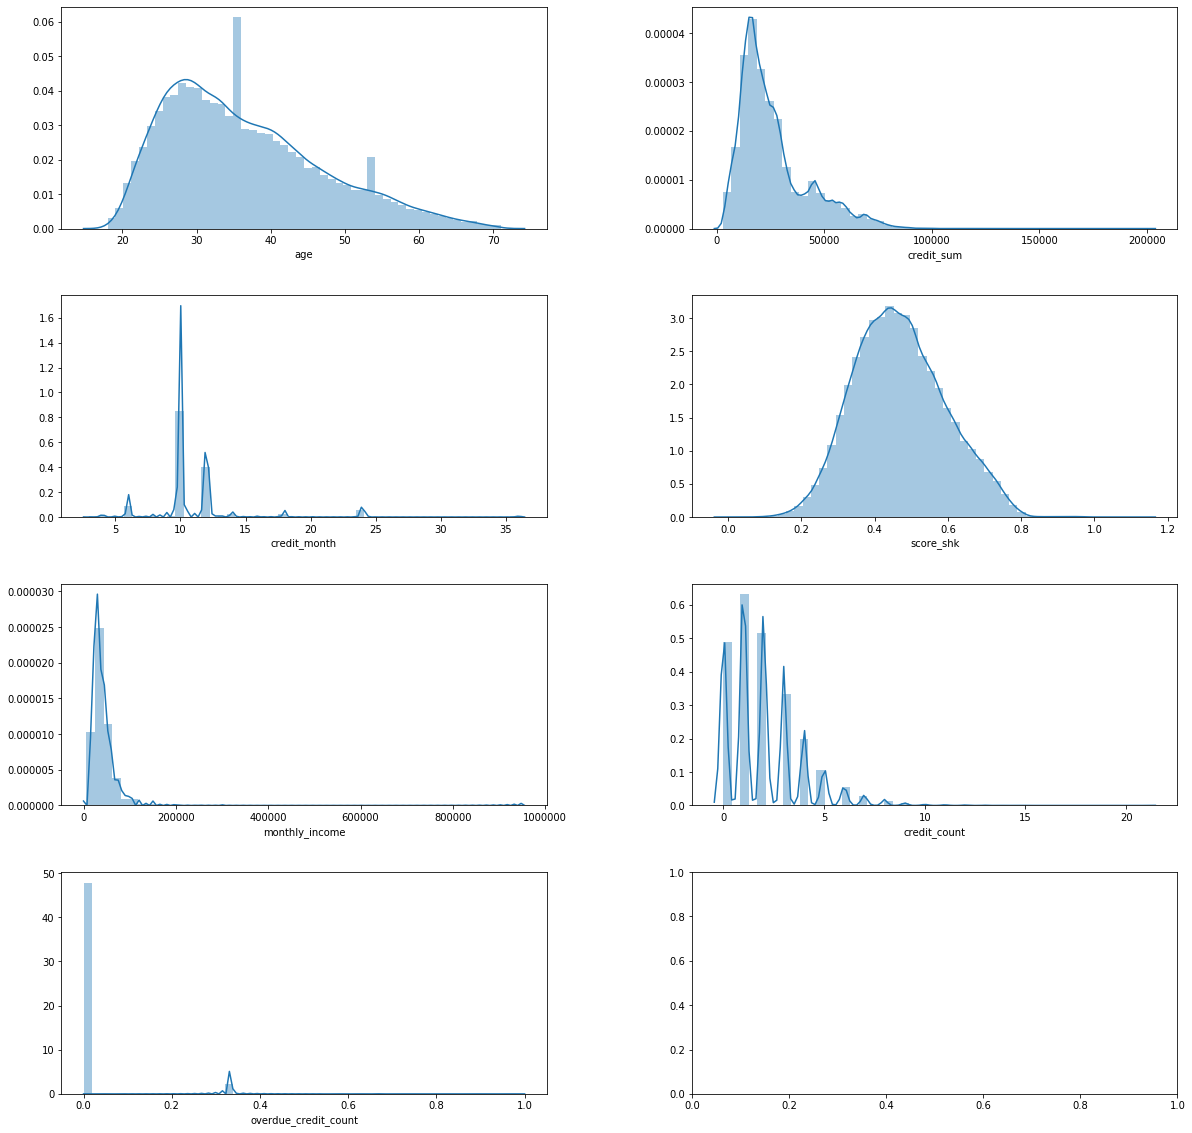

In [60]:
fig , ax = plt.subplots(4, 2,figsize=(20,20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
k=0;
for i in num_train_base.columns:
    axes = sns.distplot(num_train_base[i], ax=ax[k//2,k%2])
    axes.set(xlabel=i)
    k += 1

In [61]:
# корреляционная матрица:
corr_kendall = train_base.corr(method='kendall')
corr_kendall.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count
age,1,-0.077,-0.0074,-0.13,-0.011,0.15,0.022
credit_sum,-0.077,1,0.16,0.038,0.26,-0.0094,-0.0051
credit_month,-0.0074,0.16,1,0.069,0.0079,0.025,0.0074
score_shk,-0.13,0.038,0.069,1,-0.071,-0.12,0.13
monthly_income,-0.011,0.26,0.0079,-0.071,1,0.12,0.035
credit_count,0.15,-0.0094,0.025,-0.12,0.12,1,0.16
overdue_credit_count,0.022,-0.0051,0.0074,0.13,0.035,0.16,1


In [62]:
#Коэффициент корреляции Пирсона через функцию:
def pearsonr(x, y):
  # Assume len(x) == len(y)
  n = len(x)
  sum_x = float(sum(x))
  sum_y = float(sum(y))
  sum_x_sq = sum(map(lambda x: pow(x, 2), x))
  sum_y_sq = sum(map(lambda x: pow(x, 2), y))
  psum = sum(map(lambda x, y: x * y, x, y))
  num = psum - (sum_x * sum_y/n)
  den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
  if den == 0: return 0
  return num / den

In [65]:
y = dep_train_base
for col in columns:
    print('Коореляция Пирсона ', col, '=',
          pearsonr(train_base[col].values.astype(float), y))


Коореляция Пирсона  age = -0.03157380186473622
Коореляция Пирсона  credit_sum = -0.07366540198786203
Коореляция Пирсона  credit_month = 0.025561387611992652
Коореляция Пирсона  score_shk = 0.04754915091777508
Коореляция Пирсона  monthly_income = -0.02476304119144554
Коореляция Пирсона  credit_count = -0.0014657652748745703
Коореляция Пирсона  overdue_credit_count = 0.016423375593162523
